# 1. Install Necessary Libraries

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai

# 2. Import necessary dependencies and set environment variables

In [2]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini")

OPENAI_API_KEY: ··········


# Agentic System

An Agentic System, in the context of AI, refers to a system where one or more Agents are involved. These agents are not just passive entities that respond to commands but exhibit characteristics like:

Autonomy: They can act independently and make decisions.

Proactiveness: They can initiate actions and pursue goals.

Adaptability: They can learn and adapt to changes in their environment.

Goal-Oriented Behavior: They strive to achieve specific objectives or fulfill a particular purpose.

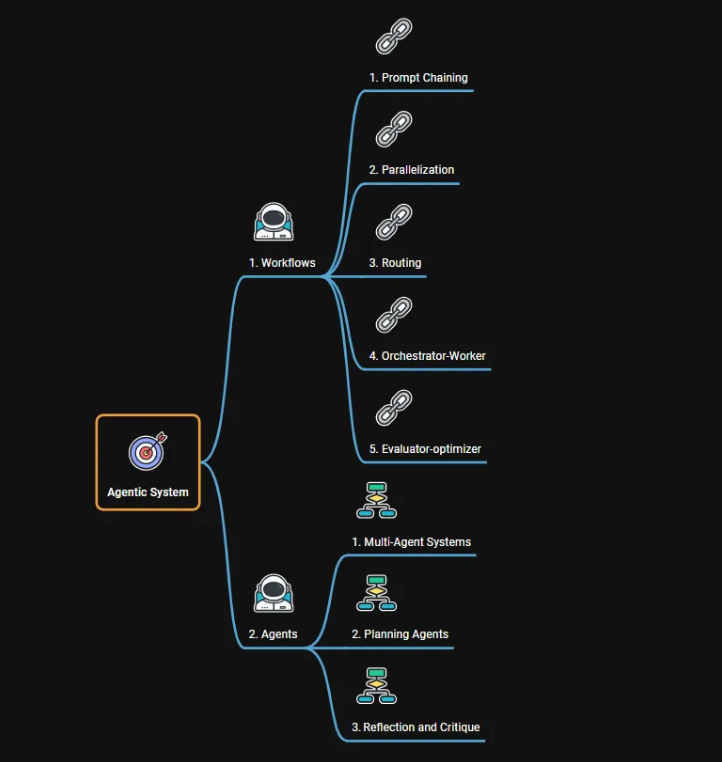

Detailed Blog : https://aiproductplaybook.substack.com/p/101-what-the-heck-are-agentic-system

# 3. Workflow - Orchestrator-Worker

In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

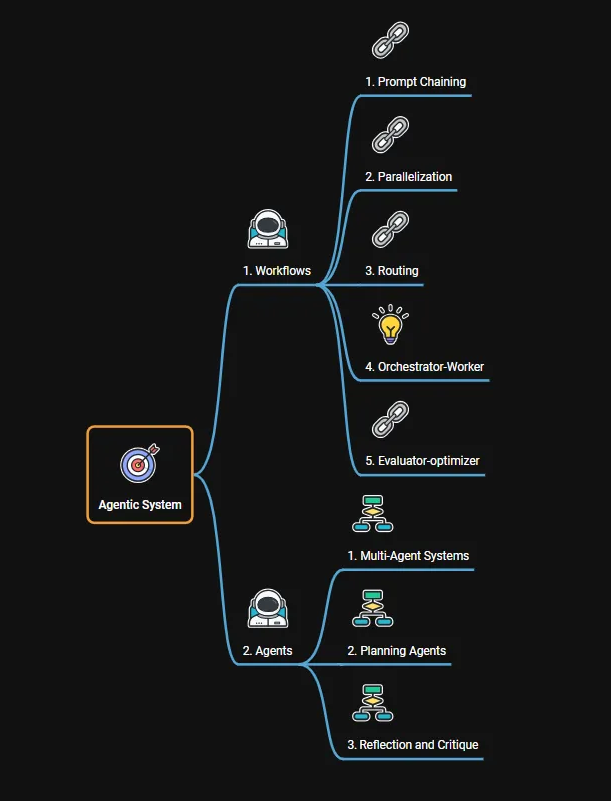

Detailed blog : https://aiproductplaybook.substack.com/p/105-what-the-heck-are-orchestrator

### a. Import LangGraph and other dependencies

In [61]:
from typing_extensions import TypedDict , Literal
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from typing import Annotated, List
import operator

### b. Defining a Schema for the list of section and augmenting the LLM with it

In [62]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### c. Defining the State Classes

This code snippet defines two classes (State and WorkerState) using TypedDict to represent the data and state of the report generation process. The State class provides a high-level overview of the entire report, while the WorkerState class focuses on the state of individual workers involved in the process.


In [63]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


### d. Defining Node Functions:

1. orchestrator(state: State) Function

This function acts as the orchestrator for the report generation process.
It takes the current state as input, which includes the topic of the report.
It uses the augmented LLM (planner) to generate a plan for the report.
It provides a system message and a human message to the planner:
The system message instructs the LLM to generate a plan for the report.
The human message provides the topic of the report to the LLM.
The planner is expected to generate a list of Section objects (as defined in the previous snippet), each with a name and a description.
The function then returns a dictionary containing the generated sections.

2. llm_call(state: WorkerState) Function

This function represents the work performed by individual workers.
It takes the WorkerState as input, which includes the section that the worker is responsible for.
It uses the LLM to generate the content for the assigned section.
It provides a system message and a human message to the LLM:
The system message provides instructions for writing the report section, including using markdown formatting.
The human message provides the name and description of the section.
The function returns a dictionary containing the generated completed_sections (a list with the generated section content).

3. synthesizer(state: State) Function

This function synthesizes the final report from the individual sections generated by the workers.
It takes the current state as input, which includes the completed_sections.
It joins the list of completed_sections using a newline and "---" as a separator to create a formatted string representing the final report.
It returns a dictionary containing the final_report.

4. assign_workers(state: State) Function

This function is responsible for assigning tasks to individual workers.
It takes the current state as input, which includes the list of sections generated by the orchestrator.
It iterates through the list of sections and creates a list of Send objects.
Each Send object represents a task to be assigned to a worker, instructing the worker to generate content for the corresponding section.

In [64]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

### e. Build workflow

This code block defines a state graph that represents a workflow for generating a report using a distributed approach. It includes nodes for the orchestrator, workers, and a synthesizer, and defines the connections between these nodes based on the dynamic output of the assign_workers function. This allows for flexible and dynamic task assignment and execution within the report generation process.

In [65]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

### f. Visualize the workflow graph

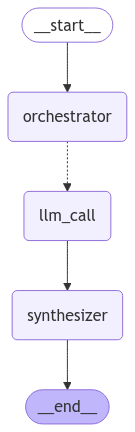

In [66]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

### g. Invoke the Workflow - Orchestrator Worker

In [67]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction to LLM Scaling Laws

Large language models (LLMs) are advanced artificial intelligence systems designed to understand and generate human-like text based on the input they receive. These models, such as OpenAI's GPT series or Google's BERT, are built upon deep learning architectures that have been trained on vast datasets containing diverse linguistic patterns. LLMs leverage immense computational resources and intricate algorithms to process natural language, enabling applications ranging from conversational agents to automated content generation.

The concept of scaling laws is crucial in the development of LLMs, as it provides insights into how model performance improves with increases in model size, training data, and computational power. Scaling laws describe the relationship between these variables, often revealing that larger models tend to achieve better results, but with diminishing returns as size continues to grow. This insight allows researchers and developers to make informed decisions regarding resource allocation and model architecture, optimizing the balance between performance and efficiency. Understanding scaling laws is essential for advancing the capabilities of LLMs while mitigating resource-related challenges in their training and deployment.

---

# Historical Context

The evolution of Large Language Models (LLMs) can be traced back to the early days of natural language processing (NLP), where the focus was primarily on rule-based systems and simpler statistical models. The advent of the Internet in the 1990s allowed for the collection of vast amounts of textual data, leading to significant advancements in NLP.

In the 2010s, the introduction of deep learning revolutionized the field. Models such as Word2Vec and GloVe laid the groundwork for representing words in a continuous vector space, enabling machines to understand semantic relationships. However, the breakthrough came with the development of the Transformer architecture in 2017, which introduced a new mechanism for processing sequential data without the constraints of recurrent networks.

The scaling of models began in earnest post-Transformer with the introduction of architectures like BERT and GPT. These models demonstrated that increasing parameters and layers could significantly enhance performance across various NLP tasks. This period marked the emergence of scaling laws, which describe how model performance improves with size—a trend that has become foundational to subsequent developments in LLMs.

As researchers continued to experiment with larger and more complex models, scaling laws became increasingly evident. For instance, OpenAI's GPT-2 and GPT-3 showcased how increased model size (from 1.5 billion to 175 billion parameters) corresponded to substantial improvements in the model's ability to generate coherent and contextually relevant text. This established a clear relationship between computational resources, model size, and performance, solidifying the strategy of building larger models to tackle more complex tasks.

The transition to extensive pre-training followed by fine-tuning on specific datasets further emphasized the benefits identified by scaling laws. As LLMs reached unprecedented parameter counts, challenges emerged—such as the resource-intensive nature of training and ethical concerns regarding biases and misinformation. Nevertheless, advancements in distributed computing and training techniques improved efficiency, allowing for continued exploration of larger architectures.

In summary, the historical context of LLMs reflects a trajectory marked by incremental innovations, driven by the principles of scaling laws. These laws have not only guided researchers in model development but have also underscored the pivotal impact of scale on performance in the ever-evolving landscape of natural language processing.

---

## Mathematical Foundations of Scaling Laws

Scaling laws in machine learning, especially in the context of large language models (LLMs), are grounded in several mathematical principles that help articulate the relationship between model size, data size, and performance. 

### Power Law Relationships

One of the core ideas in scaling laws is the observation that performance metrics often follow a power law with respect to model parameters and training data. This entails that as the model size \( N \) or the data size \( D \) increases, performance \( P \) can be represented as:

\[
P(N, D) \approx k \cdot N^{\alpha} \cdot D^{\beta}
\]

where \( k \) is a constant, and \( \alpha \) and \( \beta \) are exponents that characterize how performance improves with each additional unit of model size and data size. These exponents are often found to be positive, indicating that larger models and more data consistently lead to better performance.

### Information Theory

Another foundational aspect involves concepts from information theory, particularly the notion of entropy and how it relates to the richness of the learned representations. As models scale, their capacity to represent complex patterns increases, which can be captured by the Shannon entropy of the distributions involved. This is crucial for understanding why larger models do not merely memorize data, but instead learn more generalized patterns, thus achieving better performance on unseen data.

### Statistical Learning Theory

Scaling laws are also informed by principles from statistical learning theory, particularly the bias-variance trade-off. As model complexity increases, the bias decreases, and variance typically increases. Large models can fit the training data very well (low bias) but may overfit if not enough data is present. Scaling laws help identify the point where models transition from underfitting to overfitting, establishing thresholds for optimal data and model size combinations.

### Dimensionality and Capacity

The capacity of a model, often measured in terms of the number of parameters, plays a significant role in scaling laws. As dimensionality increases, the amount of data needed to effectively train a model also increases exponentially. This phenomenon is often described by the VC (Vapnik-Chervonenkis) dimension, which quantifies the model's capacity to capture different functions. In the context of LLMs, understanding the relationship between capacity and training data informs the practical limits of model performance.

### Empirical Validation

Finally, the empirical validation of scaling laws is heavily reliant on a large body of experimental results. Observations from training various sizes of models on diverse datasets have led to consistent patterns that affirm theoretical predictions. Linear regressions of log-transformed performance metrics against log-transformed model and data sizes often yield linear trends, supporting the established mathematical underpinnings of scaling.

In conclusion, the mathematical foundations of scaling laws in LLMs involve power law relationships, information-theoretic concepts, statistical learning principles, dimensionality considerations, and empirical evidence, establishing a robust framework for understanding model performance as a function of size and data.

---

## Empirical Findings on Scaling Laws

Recent empirical studies have provided substantial evidence supporting the scaling laws for large language models (LLMs) in relation to model size, data quantity, and training duration. These findings suggest predictable patterns in performance improvements as various parameters are adjusted.

### Model Size

Research indicates that increasing the number of parameters in an LLM consistently leads to performance gains across a variety of tasks. For instance, a study examining models of different sizes found that larger models generally achieved better results in language understanding and generation tasks. The performance improvement often follows a power-law relationship, wherein additional increases in model size yield diminishing returns; however, within certain thresholds, the enhancements are significant enough to justify the additional computational costs.

### Data Quantity

Another critical finding is the positive correlation between the volume of training data and model performance. Experiments conducted in controlled environments demonstrated that LLMs trained on diverse and expansive datasets were more adept at generalization and performing complex linguistic tasks. Incremental increases in data quantity resulted in noticeable improvements in metrics such as perplexity and task-specific accuracy. This evidence underscores the importance of large corpora in harnessing the full capabilities of larger models.

### Training Duration

The duration of training also plays a significant role in the performance of LLMs. Studies show that extending training time generally results in improved performance, although similar to model size, the effectiveness may plateau after certain periods. Detailed analyses reveal that optimal training duration depends on the available computational resources and the extent of data utilized. Models that are trained for longer periods on large datasets tend to converge to superior performance levels, as indicated by reduced loss metrics and enhanced output coherence.

### Combined Insights

When analyzing the interplay between model size, data quantity, and training duration, the findings reveal that maximizing performance often requires careful balancing of all three factors. For example, an experiment involving a series of models with varied parameters showed that the most efficient performance improvements were observable in setups where significant investment was made in both model complexity and data preparation, coupled with adequate training time.

Overall, these empirical findings strongly support the theoretical scaling laws, demonstrating that suitable adjustments to model size, data quantity, and training duration can lead to substantial enhancements in the capabilities of LLMs. This growing body of evidence provides a robust framework for future research and practical applications in the development and deployment of large language models.

---

## Implications of Scaling Laws for LLM Development

The examination of scaling laws has substantial implications for the development and optimization of Large Language Models (LLMs). These laws highlight the relationship between model size, dataset size, and performance, providing a framework for understanding how incremental changes in architecture can lead to significant gains in capabilities.

### Design Choices in LLM Architecture

1. **Model Size and Capacity**: Scaling laws elucidate that increasing the number of parameters in an LLM generally leads to improved performance on a variety of tasks. This insight drives the design choices regarding the depth (number of layers) and width (size of layers) of neural networks, emphasizing a trend towards larger architectures.

2. **Layer Configuration**: Research indicates that specific architectural designs, such as transformer-based architectures, effectively leverage scaling laws. By understanding how different layer configurations affect performance, researchers can tailor the model architecture to maximize efficiency and output quality.

3. **Attention Mechanisms**: The success of attention mechanisms in LLMs can be attributed to scaling laws that inform the design of how information flows through the model. Adjusting the scaled attention heads in relation to model size has proven effective in harnessing greater context from input data.

### Training Strategies

1. **Data Efficiency**: Scaling laws suggest that as models grow, they benefit from increased training data size to achieve optimal performance. This realization pushes the need for strategies that enhance data collection, curation, and augmentation to keep pace with model growth.

2. **Training Duration**: LLMs tend to show diminishing returns on performance improvements as training continues beyond certain thresholds. Understanding this allows researchers to refine their training schedules and methodologies, ensuring that computational resources are optimized by preventing overtraining.

3. **Curvature Dynamics**: Scaling laws demonstrate that initial gains may yield faster improvements, but as models reach larger sizes, the performance curve flattens. This aspect informs training strategies that adaptively focus on the learning rate and training dynamics to harness performance gains efficiently.

4. **Generalization vs. Overfitting**: Scaling laws provide insights into the balance between model complexity and its generalization ability. By leveraging these insights, developers can implement regularization techniques that counteract the risk of overfitting during the training process of larger models.

### Future Directions

As LLM development continues, an understanding of scaling laws will be increasingly paramount. Future architectures may lean towards hybrid models that incorporate advancements in both scaling and efficiency, allowing for the effective management of computational expense and memory usage. The ongoing research into optimal scaling strategies will likely pave the way for next-generation LLMs, capable of more nuanced understanding and output fidelity while remaining computationally feasible. 

In summary, scaling laws are central to informed decision-making regarding LLM design and training strategies, shaping both the immediate focus of research and the future trajectory of language model development.

---

## Case Studies of Notable LLMs

### GPT-3

GPT-3, developed by OpenAI, is one of the most prominent language models that exemplifies the principles of scaling laws. With 175 billion parameters, it represents a significant leap in scale compared to its predecessor, GPT-2, which featured 1.5 billion parameters. This increase not only enhances its capacity to understand and generate human-like text but also showcases how training on larger datasets yields better performance across various language tasks. 

The scaling laws manifest in GPT-3's performance metrics, where improvements in parameter count correlate with task accuracy, generalization capability, and versatility in generating coherent text across diverse topics. The model's ability to fine-tune using few-shot, one-shot, and zero-shot learning techniques highlights its adaptability, enabling efficient learning from minimal examples. 

### BERT

BERT (Bidirectional Encoder Representations from Transformers), developed by Google, offers a different but complementary perspective on scaling laws. While BERT's largest model contains 345 million parameters, its innovative bidirectional training of transformers introduces a new architectural paradigm that enhances contextual understanding significantly. 

BERT's approach demonstrates scaling laws at the level of architecture rather than sheer size. The model's performance on benchmarks like the Stanford Question Answering Dataset (SQuAD) illustrates that increased model depth and the ability to process context from both directions improve language comprehension tasks. Furthermore, BERT's success emphasizes the importance of training techniques, such as masked language modeling, which enables it to learn nuanced word relationships more effectively.

### T5

T5 (Text-to-Text Transfer Transformer) provides another compelling case study in scaling laws. It redefines NLP tasks as converting input text into output text, allowing coherent performance across a range of tasks. T5 scales from a base model with 60 million parameters to a colossal version with 11 billion parameters, illustrating how greater complexity and parameterization can lead to substantial improvements in understanding and generating language.

By leveraging a unified architecture and extensive pre-training, the scaling effects evidenced in T5 reaffirm the notion that larger models can outperform smaller counterparts in terms of generalization and task versatility. Its use of diverse datasets during training further amplifies its proficiency across areas like summarization, translation, and question answering.

### Summary

Through the analysis of GPT-3, BERT, and T5, it is evident that scaling laws play a crucial role in the design and performance of large language models. The relationship between model size and performance is not linear but reflects intricate interactions involving architectural choices, training methods, and data diversity. Each of these models highlights unique aspects of how scaling impacts capabilities within natural language processing, providing valuable insights for future developments in LLM technology.

---

## Challenges and Limitations of Scaling Laws

Scaling laws have garnered significant attention in the field of large language models (LLMs), providing insights into the relationship between model size, data quantity, and performance. However, their application is not without challenges and limitations that warrant critical examination.

### Complexity of Model Behavior

One primary challenge is the inherent complexity of LLM behaviors, which may not always conform neatly to established scaling laws. As models increase in size, the interactions between parameters become increasingly nonlinear and multifaceted. This complexity can lead to unpredictable performance outcomes that deviate from the expected improvements inferred from scaling laws.

### Data Quality and Diversity

Another limitation lies in the quality and diversity of the training data. Scaling laws assume a consistent and representative dataset; however, in practice, data may be skewed or contain biases that adversely affect model training and performance. The effectiveness of scaling laws diminishes when the underlying data does not sufficiently reflect the diversity of language use and contextual applications.

### Diminishing Returns

As LLMs become larger, diminishing returns in performance enhancements are frequently observed. Although early increases in model size can yield substantial gains, the incremental benefits often taper off, challenging the notion that larger is always better. This phenomenon raises questions about the practical utility and cost-effectiveness of pursuing larger models.

### Computational and Environmental Constraints

The computational resources required for training increasingly large models pose significant challenges. Large-scale training demands substantial hardware investments and energy consumption, leading to concerns about sustainability and environmental impact. These constraints may limit the feasibility of scaling laws for adoption in real-world applications, especially in resource-constrained environments.

### Overshadowing of Smaller Models

The focus on scaling laws can overshadow the potential utility of smaller, more efficient models. As emphasis shifts toward creating larger networks, there is a risk of neglecting the development of models that can achieve competitive performance with fewer resources. This gap could hinder innovation in developing lightweight models that are easier to deploy in practical applications.

### Interpretability and Control

Finally, as models grow in size, issues surrounding interpretability and control become more pronounced. Larger LLMs tend to operate more like black boxes, making it challenging to understand their decision-making processes. This lack of transparency raises concerns about trust and reliance on LLM outputs, further complicating the practical application of scaling laws.

In conclusion, while scaling laws offer valuable frameworks for understanding the dynamics of model size and performance, a critical appraisal reveals significant challenges and limitations. Recognizing these factors is essential for developing robust LLMs that effectively leverage scaling while addressing practical concerns in deployment and accessibility.

---

## Future Directions in LLM Research

The landscape of large language models (LLMs) is evolving rapidly, and several key areas of future research are emerging that hold significance for both scaling laws and broader AI development.

### Understanding Scaling Laws

Research on scaling laws has been pivotal in shaping the design and effectiveness of LLMs. Future studies are expected to probe the mathematical relationships that govern performance improvements in relation to model size, data quantity, and training duration. By refining our understanding of these scaling laws, researchers will be able to predict more accurately the resource requirements for achieving higher performance in various tasks.

### Efficiency and Sustainability

As LLMs grow larger, the environmental impact and computational costs become pressing concerns. Future research will likely focus on developing more efficient training algorithms, such as those that optimize memory usage and reduce carbon footprints. Techniques like model distillation, pruning, and the exploration of low-rank approximations can contribute to creating smaller yet highly effective models, thereby addressing sustainability challenges.

### Robustness and Generalization

The robustness and generalization of LLMs in real-world applications will continue to be a critical area of investigation. Future work may explore adversarial training methods and domain adaptation strategies to enhance performance across diverse tasks. This includes researching ways to improve the adaptability of LLMs to niche or low-resource domains, ultimately promoting inclusive AI applications.

### Multimodal Capabilities

The integration of multimodal inputs, encompassing text, images, audio, and video, is an exciting direction for LLM research. As technology progresses, future LLMs may need to better understand and generate responses that merge different forms of media. This could entail substantial advancements in neural architectures that can handle multimodal data efficiently.

### Ethical Considerations and Bias Mitigation

With the advancement of LLMs, the importance of ethical considerations and bias mitigation will intensify. Future research will likely prioritize the development of frameworks to identify, measure, and mitigate biases present in training data and model outputs. Establishing guidelines for transparent and responsible AI usage will be essential as LLMs become more ingrained in everyday applications.

### Collaborative AI Systems

Future research may also extend into the development of collaborative AI systems, where LLMs work in tandem with humans and other AI systems. Investigating how to create seamless interactions between LLMs and users could lead to enhanced user experiences and more intuitive toolsets capable of assisting in decision-making and creativity.

### Regulatory and Compliance Frameworks

As LLMs become more prevalent across industries, there will be a need for thoughtful regulatory frameworks that govern AI deployment. Future research could contribute to establishing best practices, compliance measures, and audit mechanisms that ensure the ethical and responsible use of LLMs across different contexts.

In summary, the future of LLM research promises to be multifaceted, addressing both the technical challenges of scaling and broader implications for ethics, sustainability, and societal impact. As advancements continue, the focus will likely remain on not just enhancing model capabilities, but also ensuring their responsible integration into daily life.

---

## Conclusion

In this report, we examined the evolution and implications of scaling laws in the advancement of large language models (LLMs). The following key points have been discussed:

1. **Definition of Scaling Laws**: Scaling laws reveal the relationship between model size, training data, and performance metrics, illustrating how increasing these variables can enhance the efficacy of LLMs.

2. **Empirical Findings**: Numerous studies show that larger models consistently outperform smaller counterparts until a saturation point is reached, indicating diminishing returns on performance relative to further increases in size or data.

3. **Resource Allocation**: The necessity of substantial computational resources for training large models has implications for accessibility, equity, and innovation within the field of artificial intelligence.

4. **Performance vs. Complexity**: As models scale, complexity increases, which can lead to challenges related to interpretability, control, and ethical considerations in their deployment.

5. **Future Directions**: Continued research into the theoretical underpinnings of scaling laws may yield insights that inform the design of more efficient models, potentially leading to advancements without linear increases in resource demands.

The broader significance of scaling laws lies in their capacity to guide researchers and practitioners in the development of LLMs. Understanding these principles is crucial for optimizing performance and efficiency, fostering innovation, and addressing challenges associated with AI ethics and governance. As industries increasingly rely on LLMs for decision-making and customer interaction, the implications of scaling laws will continue to shape the landscape of artificial intelligence, driving both technological advancement and societal impact.

In [71]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Bitcoin adoption as store of value"})

from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction to Bitcoin

Bitcoin is the first decentralized digital currency, introduced in 2009 by an unknown person or group of people using the pseudonym Satoshi Nakamoto. The primary motivation behind Bitcoin's creation was to establish a peer-to-peer electronic cash system that would allow online payments to be sent directly from one party to another without going through a financial institution. The revolutionary underlying technology of Bitcoin, known as blockchain, is a distributed ledger that ensures transparency, security, and immutability of transactions.

Since its inception, Bitcoin has undergone significant evolution. Initially, it was primarily utilized by tech enthusiasts and those skeptical of traditional banking systems. Over the years, Bitcoin's acceptance has grown, gaining popularity among investors, businesses, and even government entities. Its status has transformed from a niche digital asset, often associated with illicit activities, to a widely recognized store of value and a digital gold alternative. This evolution can be attributed to growing public awareness, technological advancements, and increasing institutional adoption.

At the core of Bitcoin's significance is its potential to serve as a store of value, akin to gold. A store of value is an asset that maintains its value over time without depreciating and can be used for future transactions. Bitcoin's limited supply—capped at 21 million coins—creates scarcity, which may enhance its value over time, especially in economies facing currency devaluation or inflation. This characteristic has drawn investors seeking a safe haven in an increasingly unstable financial landscape. 

Moreover, as traditional financial systems struggle with issues like inflation and centralized control, Bitcoin offers an alternative that underscores the need for autonomy over one's financial assets. Its decentralized nature protects against government interference and potential mismanagement, further boosting its appeal as a store of value. Thus, Bitcoin's emergence as a digital currency not only marks a technological milestone but also signals a shift in how we perceive and utilize money in the modern economy.

---

## Historical Context of Bitcoin Adoption

The inception of Bitcoin in 2009 marked the beginning of a revolutionary era in digital finance. Conceived by an anonymous figure (or group) known as Satoshi Nakamoto, Bitcoin introduced the concept of a decentralized cryptocurrency, underpinned by blockchain technology. The early adoption of Bitcoin was characterized by a niche community of tech enthusiasts and cryptographers, largely unaware of the transformative potential it held.

One of the first significant milestones in Bitcoin's journey was its first recorded transaction in 2010 when programmer Laszlo Hanyecz famously paid 10,000 BTC for two pizzas. This event, often revered in the crypto community, underscored Bitcoin's utility as a medium of exchange and highlighted its nascent economic value, albeit at a highly speculative stage.

The introduction of Bitcoin exchanges in 2010, such as Mt. Gox, provided a marketplace for trading Bitcoin, enabling broader accessibility to the digital asset. This pivotal development attracted early investors and traders, fostering greater liquidity and price discovery. Over time, the value of Bitcoin began to gain momentum, reaching a notable milestone of $1 in February 2011, which marked a psychological breakthrough and expanded its recognition beyond fringe communities.

The rise of Bitcoin was punctuated by several key events, including the infamous 2013 Silk Road scandal, where Bitcoin gained notoriety as the preferred currency for illegal transactions. Despite the negative connotations, it simultaneously highlighted Bitcoin's potential as a borderless and anonymous financial tool. Furthermore, the subsequent crackdown on Silk Road increased public awareness and curiosity about cryptocurrency, yielding an influx of new users.

As cryptocurrencies gained attention, influential figures and organizations began endorsing Bitcoin. In 2013, the U.S. Senate held a hearing on the potential impact of virtual currencies, signifying a growing recognition of bitcoin’s place within the financial landscape. The subsequent interest from investment firms, alongside media coverage, further legitimized Bitcoin as a nascent asset class.

By 2017, Bitcoin experienced its first major price surge, reaching nearly $20,000 by December. This spike was driven by increased consumer interest, mainstream media coverage, and the rise of Initial Coin Offerings (ICOs), which brought further speculation into the arena. While volatile, this period cemented Bitcoin’s position in the public consciousness as "digital gold," with many investors beginning to view it as a store of value instead of merely a speculative asset.

In conclusion, the early days of Bitcoin's adoption cultivated a foundation for its evolution into a recognized store of value. Key events and milestones, including the establishment of exchanges, early transactions, and significant media coverage, shaped its journey. Today, Bitcoin stands as a transformative asset with an increasing role in diversifying investment portfolios and challenging traditional financial paradigms.

---

## Analyzing Bitcoin's Characteristics as a Store of Value

Bitcoin exhibits several key properties that contribute to its viability as a store of value. These characteristics include scarcity, portability, divisibility, and durability, each playing a significant role in its function as a digital asset.

### Scarcity

Bitcoin is designed with a capped supply of 21 million coins, which endows it with inherent scarcity. This limit is enshrined in its protocol and is a fundamental aspect that distinguishes Bitcoin from fiat currencies, which can be printed at will by central banks. The predictable issuance of new bitcoins, facilitated by a process called halving, ensures that the rate of supply slows over time, creating a deflationary dynamic that can enhance its value over the long term. This scarcity is akin to precious metals, such as gold, which also derive part of their value from limited availability.

### Portability

Bitcoin can be transferred easily across the globe, making it highly portable compared to traditional assets like real estate or precious metals. Transactions can occur 24/7 without the need for intermediaries, and users can send or receive bitcoins through a variety of digital wallets, making it accessible from anywhere with an internet connection. This instantaneous nature of transactions enhances its desirability as a store of value, allowing for quick transfers without lengthy settlement processes typically associated with traditional financial systems.

### Divisibility

Bitcoin is highly divisible, with each bitcoin divisible into 100 million smaller units known as satoshis. This allows for fractional ownership and enables users to transact in smaller amounts, making it practical for both high-value investments and everyday purchases. Such divisibility ensures that Bitcoin can be utilized across various price points, accommodating a wide range of economic activities and individual preferences, thus enhancing its functionality as a medium of exchange as well as a store of value.

### Durability

As a digital asset, Bitcoin does not incur the physical degradation that tangible assets face over time. It is stored securely on a blockchain, an immutable ledger that ensures the integrity and longevity of its existence. Unlike physical commodities, which can be subject to wear and tear, Bitcoin remains intact as long as the underlying technology and network are maintained. This digital robustness contributes to its appeal as a reliable store of value that is resistant to loss or damage.

### Conclusion

In summary, Bitcoin's characteristics of scarcity, portability, divisibility, and durability position it as a compelling store of value in the digital age. These features not only enhance its attractiveness compared to traditional assets but also provide a framework for understanding the growing adoption of Bitcoin in financial markets globally. As the cryptocurrency landscape continues to evolve, the intrinsic properties of Bitcoin will likely play a crucial role in shaping its future as an established store of value.

---

## Comparative Analysis: Bitcoin vs. Traditional Stores of Value

### Overview

Bitcoin, often referred to as digital gold, has emerged as a popular alternative to traditional stores of value like gold and real estate. This comparative analysis explores the advantages and disadvantages of Bitcoin in contrast to these conventional assets.

### Advantages of Bitcoin

1. **Liquidity**: 
   - Bitcoin can be traded 24/7 on numerous exchanges, providing instant liquidity. Traditional assets like real estate and even gold can often take longer to liquidate.

2. **Portability**: 
   - Bitcoin is entirely digital, allowing for easy transfer across borders. In comparison, gold requires physical storage and transportation, while real estate involves logistical complexities.

3. **Accessibility**: 
   - Anyone with internet access can buy, sell, and trade Bitcoin, which democratizes access to investment opportunities. In contrast, investing in real estate often requires significant capital and has higher entry barriers.

4. **Divisibility**: 
   - Bitcoin can be divided into smaller units (satoshis), allowing for precise investment amounts. Gold and real estate are not as easily divisible, making fractional ownership more complicated.

5. **Transparency and Security**: 
   - Bitcoin transactions are recorded on a public ledger (blockchain), enhancing transparency. Once secured, transactions are immutable. Traditional stores of value are more susceptible to fraud and require intermediaries to ensure security.

### Disadvantages of Bitcoin

1. **Volatility**: 
   - Bitcoin is known for its price volatility, which can lead to significant fluctuations in value over short periods. In contrast, gold and real estate typically offer more stable value retention.

2. **Regulatory Uncertainty**: 
   - The regulatory landscape for cryptocurrencies like Bitcoin is still evolving, leading to potential uncertainties that can affect its use as a store of value. Traditional assets benefit from established legal protections.

3. **Lack of Intrinsic Value**: 
   - Unlike gold, which has industrial uses and is universally recognized as valuable, Bitcoin does not have intrinsic value nor physical form, relying solely on market perception.

4. **Technological Barriers**: 
   - Bitcoin requires a basic understanding of digital wallets, private keys, and blockchain technology, which can be daunting for some investors. Traditional stores of value like gold and real estate do not have such technological dependencies.

5. **Market History**: 
   - Bitcoin is a relatively new asset, having been created in 2009. In contrast, gold has been a store of value for millennia and real estate for hundreds of years, providing a more extensive historical data set for investors to analyze.

### Conclusion

In summary, Bitcoin presents a modern alternative to traditional stores of value such as gold and real estate, with clear advantages in liquidity, portability, and accessibility. However, its volatility, regulatory uncertainties, and reliance on technology pose significant risks. As the financial landscape evolves, the role of Bitcoin as a competitive store of value will continue to develop, requiring ongoing analysis and understanding from investors.

---

## Current Trends in Bitcoin Adoption

As of October 2023, Bitcoin continues to gain traction as a dominant digital asset, increasingly recognized as a store of value among a diverse range of adopters, including individuals, businesses, and institutional investors.

### Individual Adoption

Personal adoption of Bitcoin has surged, with increased awareness and education contributing to its appeal as a hedge against inflation and economic instability. A significant portion of the population now views Bitcoin as a means to diversify their investment portfolios. User-friendly platforms and mobile wallets have lowered entry barriers, allowing users to buy, store, and transact with Bitcoin more conveniently. Additionally, the rise of Bitcoin ATMs and peer-to-peer trading platforms has facilitated accessible entry points for individuals who prefer direct ownership over exchange-based transactions.

### Business Adoption

Businesses are increasingly integrating Bitcoin into their operations. Many retailers and service providers are beginning to accept Bitcoin as a form of payment, driven by rising consumer demand for cryptocurrency options. Major companies in sectors like technology, e-commerce, and hospitality have adopted Bitcoin payments, recognizing it as a valuable tool for attracting tech-savvy customers. Moreover, businesses are also leveraging Bitcoin as a means of capital preservation, with companies like Tesla and MicroStrategy publicly investing in Bitcoin as part of their treasury strategy.

### Institutional Adoption

Institutional interest in Bitcoin has reached unprecedented levels, with various asset management firms, hedge funds, and sovereign wealth funds entering the market. This trend is driven by the growing recognition of Bitcoin as 'digital gold', alongside its potential for high returns amidst low-interest-rate environments. Several financial institutions are now offering Bitcoin-related products, including ETFs and custodial services, reflecting a shift in perception from skepticism to acceptance. The presence of cryptocurrency on the balance sheets of established financial players adds a layer of legitimacy and encourages further investments from other institutions.

### Regulatory Environment

The regulatory landscape surrounding Bitcoin adoption continues to evolve, with governments and regulatory bodies worldwide assessing frameworks to accommodate cryptocurrency activities. While uncertainty remains in some jurisdictions, clear regulations in others have fostered a more secure environment for both retail and institutional investors. Enhanced compliance measures and consumer protections are helping to build trust, encouraging broader adoption among those previously hesitant to enter the market.

### Conclusion

The current landscape of Bitcoin adoption is marked by steady growth across individuals, businesses, and institutions. Its appeal as a store of value and a hedge against economic uncertainty is driving widespread acceptance. As regulatory clarity improves and technological advancements facilitate easier access, it is likely that Bitcoin's role as a mainstream asset will continue to solidify in the coming years.

---

## Case Studies

### Case Study 1: MicroStrategy Inc.

**Background**: MicroStrategy, a business intelligence company, became one of the first publicly traded companies to adopt Bitcoin as its primary treasury reserve asset. The company's CEO, Michael Saylor, has been an outspoken advocate for Bitcoin.

**Motivations**:
- **Inflation Hedge**: Saylor and his team view Bitcoin as a safeguard against inflationary pressures, particularly in a low-interest-rate environment.
- **Long-term Value Appreciation**: The belief in Bitcoin's potential to appreciate significantly in value over time compared to traditional fiat currencies.
- **Corporate Treasury Strategy**: Shifting from conventional cash reserves to a more resilient asset to enhance shareholder returns.

**Outcomes**:
- **Capital Growth**: MicroStrategy's investments in Bitcoin have resulted in substantial capital appreciation, showcasing the potential of Bitcoin as a store of value.
- **Increased Market Interest**: The company's high-profile Bitcoin purchases have drawn attention from other institutional investors, leading to a broader acceptance within corporate treasury strategies.
- **Volatility Concerns**: Despite the gains, the company has faced challenges related to Bitcoin's price volatility, impacting its stock performance and financial statements.

### Case Study 2: The City of Lugano

**Background**: The city of Lugano in Switzerland has implemented a plan to accept Bitcoin for tax payments and other municipal services, promoting Bitcoin as a legitimate currency option.

**Motivations**:
- **Economic Development**: By embracing Bitcoin, Lugano aims to attract crypto-driven businesses and investors, stimulating local economic growth.
- **Modernization of Financial Systems**: The city seeks to modernize its financial system by incorporating digital currencies, enhancing the fintech landscape in the region.
- **Diversification of Assets**: Encouraging citizens and businesses to consider Bitcoin as part of their financial portfolios for long-term value retention.

**Outcomes**:
- **Increased Adoption**: The initiative has helped increase Bitcoin transactions, showcasing a tangible use case for citizens and businesses alike.
- **Community Engagement**: Crypto-related events and initiatives in Lugano have fostered community engagement and educational opportunities regarding digital assets.
- **Regulatory Challenges**: Despite initial enthusiasm, the city faces ongoing regulatory and technical challenges as it navigates the integration of Bitcoin into its public services.

### Case Study 3: HODL Waves Analysis by Glassnode

**Background**: Glassnode, a blockchain analytics firm, has conducted research using their HODL Waves metric, analyzing the behavior of Bitcoin holders over time.

**Motivations**:
- **Long-term Investment Strategy**: Many Bitcoin investors adopt a long-term holding strategy, driven by the belief in Bitcoin’s future value rather than short-term profits.
- **Market Psychology**: Understanding the psychology behind HODLing provides insights into market sentiment and the commitment of investors to Bitcoin as a store of value.

**Outcomes**:
- **Investment Insights**: The HODL Waves analysis indicates a growing number of long-term investors, suggesting increased confidence in Bitcoin as a store of value.
- **Resilience to Sell-offs**: The data shows that despite market volatility, long-term holders are less likely to sell during downturns, contributing to price stability.
- **Emerging Patterns**: Periodic spikes in HODL Waves correlate with broader adoption trends and institutional interest, underscoring Bitcoin’s evolution as a recognized asset class.

### Case Study 4: The Venezuelan Diaspora

**Background**: Amid economic turmoil and hyperinflation, many Venezuelans have turned to Bitcoin for remittances and as a means to preserve wealth.

**Motivations**:
- **Inflation Protection**: With the Venezuelan Bolívar losing value rapidly, many individuals use Bitcoin to protect their savings from hyperinflation.
- **Accessibility**: Bitcoin provides a means for the underbanked population to engage in the global economy without relying on traditional financial systems.
- **Remittances**: Many Venezuelans abroad send Bitcoin back home, facilitating faster and cheaper remittance transfers.

**Outcomes**:
- **Financial Stability**: For many individuals, converting local currency to Bitcoin has provided a semblance of financial stability amid economic chaos.
- **Crypto Adoption Growth**: The necessity of using Bitcoin has spurred greater adoption and understanding of cryptocurrencies within the Venezuelan community.
- **Regulatory Scrutiny**: As Bitcoin usage has increased, the Venezuelan government has expressed interest in regulating the space, highlighting both potential and risk for users.

### Summary

These case studies highlight the diverse motivations behind the adoption of Bitcoin as a store of value among individuals and organizations. From corporate strategies to community-level impacts, the outcomes reflect a growing acceptance and integration of Bitcoin into economic activities. However, challenges regarding volatility and regulatory environments remain critical considerations for prospective adopters.

---

## Regulatory Environment

The regulatory landscape surrounding Bitcoin has evolved significantly since its inception, impacting its adoption and perception as a store of value. Governments across the globe have taken diverse approaches to cryptocurrency regulation, ranging from outright bans to the establishment of comprehensive legal frameworks.

### Impact on Adoption

Regulatory clarity can enhance Bitcoin's adoption by providing users and investors with a degree of security and assurance. Jurisdictions that have embraced Bitcoin, such as El Salvador, which officially recognized it as legal tender, have seen increased usage among their populations. In contrast, countries with harsh regulations or prohibitions, like China, have experienced declining participation in the Bitcoin ecosystem, stifling potential growth and innovation.

Furthermore, regulations aimed at combating money laundering (AML) and know-your-customer (KYC) requirements have prompted exchanges to enhance their security protocols. While such measures may create initial hurdles for users, they ultimately foster trust in the cryptocurrency market, encouraging more people to invest and use Bitcoin as a transactional medium.

### Role as a Store of Value

Regulatory policies profoundly influence Bitcoin’s perception as a store of value. In countries experiencing hyperinflation or economic instability, Bitcoin has emerged as a hedge against currency devaluation. Regulatory acceptance can bolster this role, as seen in jurisdictions where Bitcoin is recognized as a legitimate financial asset, attracting institutional investment as a digital gold alternative.

Conversely, regulatory uncertainty can undermine Bitcoin's status as a safe haven. For instance, policies that impose stringent taxation or restrictions on trading could deter both retail and institutional investors, leading to price volatility. The duality of regulation—where it can act both as a facilitator and a barrier—highlights the complex interplay between policy, market dynamics, and Bitcoin's long-term viability as a store of value.

### Future Outlook

As discussions surrounding the regulation of cryptocurrencies gain momentum in various governments, the future of Bitcoin will likely be shaped by these decisions. An increasing number of regulatory bodies are now exploring frameworks that aim to strike a balance between promoting innovation and protecting consumers. The outcome of these deliberations will play a critical role in determining Bitcoin's path forward, particularly as it strives to solidify its position as a reliable store of value in the global financial system. 

In summary, the regulatory environment remains a key determinant in Bitcoin’s adoption and its functionality as a store of value. As regulations evolve, they will continue to influence the cryptocurrency's trajectory, impacting investor confidence and market stability.

---

## Future Outlook for Bitcoin as a Store of Value

As Bitcoin matures within the financial landscape, its potential to serve as a store of value continues to spark interest and debate among investors, regulators, and financial experts. Several trends, challenges, and opportunities are expected to shape Bitcoin's role in this arena over the coming years.

### Trends

1. **Institutional Adoption**: Institutional investment in Bitcoin has been on the rise, with hedge funds, publicly traded companies, and asset management firms incorporating Bitcoin into their portfolios. This trend suggests a growing belief in Bitcoin's viability as a long-term store of value.

2. **Regulatory Clarity**: As governments worldwide work toward establishing clear regulatory frameworks for cryptocurrencies, increased compliance and legitimacy may encourage more investors to treat Bitcoin as a stable asset. This regulatory clarity could enhance trust and facilitate broader adoption.

3. **Digital Gold Narrative**: Bitcoin has increasingly been referred to as "digital gold." As traditional gold faces its own challenges, Bitcoin could capture a greater share of the store of value market, especially among younger investors who are more comfortable with digital assets.

4. **Technological Advances**: Improvements in blockchain technology, including the development of Layer 2 solutions like the Lightning Network, may address scalability and transaction speed issues. This could enhance Bitcoin’s usability, making it more attractive as a reliable store of value.

### Challenges

1. **Volatility**: Bitcoin is known for its price volatility, which can deter investors looking for stable stores of value. Unless mechanisms are established to reduce this volatility, Bitcoin may struggle to dethrone traditional assets such as gold and real estate.

2. **Market Saturation**: The proliferation of cryptocurrencies can dilute Bitcoin's market share as new entrants offer similar features and value propositions. Competing digital assets may hinder Bitcoin's establishment as the dominant store of value.

3. **Environmental Concerns**: Bitcoin mining’s environmental impact poses a significant challenge, especially as sustainability becomes a priority for many investors. Increased scrutiny on energy consumption may lead to regulatory changes that could affect mining operations and Bitcoin's perception as a "clean asset."

4. **Technological Risks**: While advancements in technology offer opportunities, they also present risks. Security vulnerabilities, bugs in code, or potential improvements in alternative cryptocurrencies could undermine Bitcoin’s appeal.

### Opportunities

1. **Diversification Strategy**: Bitcoin can appeal to investors as a diversification tool in their portfolios, potentially offering a hedge against inflation and economic downturns. Increased recognition of this role could drive higher demand.

2. **Global Financial Inclusion**: Bitcoin's decentralized nature allows for greater access to financial services, especially in underbanked regions. As more individuals turn to Bitcoin as a reliable alternative to traditional banking, its adoption as a store of value could increase.

3. **Integration with Traditional Finance**: The growing interest in Bitcoin-based financial products, such as ETFs and futures contracts, indicates a merging of traditional finance with digital assets. Such products may further legitimize Bitcoin as a store of value in conventional investment circles.

4. **Evolving Investor Demographics**: As younger generations begin to invest, their preferences for digital assets may shift the dynamics of value storage. This generational change presents a significant opportunity for Bitcoin to capture a market share traditionally dominated by other stores of value.

In summary, while Bitcoin encounters various challenges as it seeks to solidify its role as a store of value, a range of emerging trends and opportunities are likely to aid its evolution. Continued observation of market developments, technological advancements, and regulatory changes will be crucial in evaluating Bitcoin’s future position in the financial ecosystem.

---

## Conclusion

This report has highlighted the transformative impact of Bitcoin on the global financial landscape. Key findings indicate that Bitcoin continues to serve as a decentralized digital currency, providing users with an alternative to traditional fiat systems. Its role as a store of value has gained prominence, particularly during times of economic uncertainty, where it is frequently likened to "digital gold."

Moreover, the increasing acceptance of Bitcoin by institutional investors has underscored its legitimacy and potential as a long-term investment. The institutional adoption illustrates a significant shift in perception, indicating that Bitcoin is not just a speculative asset but a viable component of modern financial portfolios.

Regulatory developments have also played a crucial role in shaping Bitcoin's future. Countries worldwide are beginning to establish clearer frameworks for cryptocurrency, which can enhance consumer protections and facilitate broader adoption. This regulatory clarity is essential for fostering innovation within the blockchain space while mitigating potential risks associated with digital currencies.

Furthermore, the evolving technological landscape surrounding Bitcoin, including advancements in scalability and security, positions it as a resilient player in the financial ecosystem. As the network continues to grow and improve, it is likely that Bitcoin will further solidify its standing as a key player in both the alternative currency sector and the broader economic framework.

In conclusion, Bitcoin has emerged as a pivotal asset in the evolving financial landscape, influencing investment strategies, regulatory approaches, and technological innovations. Its unique characteristics and growing acceptance suggest that it will remain a significant force in the finance industry for the foreseeable future.

In [72]:
with open("report.md", "w") as f:
    f.write(state["final_report"])

In [73]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Foundational LLM models"})

from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction to Foundational LLM Models

Foundational Large Language Models (LLMs) are advanced artificial intelligence systems designed to understand, generate, and manipulate human language. These models are characterized by their capacity to process vast amounts of textual data, leveraging complex algorithms and neural network architectures to learn patterns, contexts, and nuances in language. The significance of LLMs in natural language processing (NLP) is profound, as they serve as the backbone for numerous applications ranging from chatbots and virtual assistants to content creation and automated translation services. 

The development of foundational LLMs traces back to key milestones in both machine learning and NLP. Early models like n-grams and rule-based systems laid the groundwork for more sophisticated approaches. The advent of neural networks, particularly Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks, marked a turning point, allowing for better sequence prediction and language understanding.

However, the conceptual leap came with the introduction of transformers in 2017 by Vaswani et al., which revolutionized language modeling through self-attention mechanisms. This innovation enabled models to weigh the significance of each word in context, regardless of its position in a sentence. The subsequent release of BERT (Bidirectional Encoder Representations from Transformers) by Google and its successors, including GPT (Generative Pre-trained Transformer) by OpenAI, set new benchmarks in NLP, achieving impressive results in various tasks like sentiment analysis, question-answering, and summarization.

In summary, foundational LLMs represent a significant evolution in the capabilities of NLP, built on decades of research and technological advancements. Their ability to understand and generate human-like text continues to transform how we interact with machines and process information.

---

## Architecture of Foundational LLMs

Foundational Large Language Models (LLMs) have fundamentally transformed the landscape of natural language processing (NLP) through a novel architecture characterized primarily by transformer models. This section delves into the key components that define the architecture of these models, with a specific focus on transformers and attention mechanisms, while also highlighting how they diverge from traditional NLP architectures.

### Transformer Models

The backbone of foundational LLMs is the transformer architecture, introduced by Vaswani et al. in 2017. The core innovation of transformers lies in their ability to process input data in parallel rather than sequentially, as was typical with earlier models like recurrent neural networks (RNNs) and long short-term memory networks (LSTMs). This parallel processing capability not only speeds up training times significantly but also allows the model to capture contextual relationships more effectively.

Transformers consist of an encoder-decoder structure, albeit many LLMs primarily utilize the encoder part. The encoder processes input text into a series of continuous representations, enabling the model to learn patterns and structures within the data. Each encoder layer comprises two components: multi-head self-attention and position-wise feed-forward networks.

### Attention Mechanisms

Attention mechanisms are central to the transformer's performance. The multi-head self-attention allows the model to weigh the importance of different words in a sentence when generating their representations. Each attention head focuses on different parts of the input, enabling the model to capture various relationships and nuances in language simultaneously.

The attention mechanism operates based on three components for each input word: Query (Q), Key (K), and Value (V). The attention scores are calculated by taking the dot product of the Query and Key vectors, followed by a normalization step, resulting in a value that indicates the relevance of one word to another. This score is then used to create a weighted combination of the Value vectors, determining the final representation of the input word in the context of the surrounding text.

### Differences from Traditional NLP Models

Traditional NLP models like RNNs, LSTMs, and n-grams largely relied on sequential processing and local context, which limited their ability to capture long-range dependencies within text. These models often struggled with the vanishing gradient problem, which impeded training efficiency and effectiveness over extended sequences.

In contrast, the transformer model's ability to utilize self-attention allows it to maintain global context effectively. It can attend to any word in the input sequence regardless of its position. This results in significantly enhanced performance on a wide range of NLP tasks, such as translation, summarization, and question answering.

Moreover, traditional models typically required feature engineering and hand-crafted rules to perform tasks effectively, whereas foundational LLMs can learn representations directly from vast amounts of unstructured text data without such manual intervention. This characteristic, combined with the scalability of transformers, allows LLMs to achieve impressive levels of performance that surpass traditional approaches.

### Conclusion

The architecture of foundational LLMs marks a paradigm shift in how language understanding and generation tasks are approached in NLP. The combination of transformer architecture and self-attention mechanisms provides a robust framework that outperforms traditional models by enabling parallel processing and effective context management. As research continues to evolve in this area, the architectural advancements are likely to further influence the development of future NLP technologies.

---

## Key Foundational LLM Models

### GPT-3 (Generative Pre-trained Transformer 3)
GPT-3, developed by OpenAI, is one of the most notable advancements in natural language processing. It consists of 175 billion parameters, making it one of the largest language models to date. 

**Features:**
- **Generative in Nature**: Capable of producing human-like text based on prompts, which makes it useful for a variety of applications such as chatbots, content creation, and more.
- **Few-Shot Learning**: Demonstrates impressive performance with minimal examples, allowing it to generalize from fewer training instances.

**Strengths:**
- **Versatility**: Excels across numerous NLP tasks without task-specific training, including translation, summarization, and question-answering.
- **Contextual Understanding**: Remarkable ability to generate contextually relevant text due to its capability to consider a vast amount of input data.

**Implementations:**
- Widely utilized in applications ranging from automated customer service to creative writing tools, as well as in academic research to explore AI-enhanced learning.

### BERT (Bidirectional Encoder Representations from Transformers)
BERT, introduced by Google, revolutionizes the way language models capture context in text. Unlike traditional models, BERT processes text bidirectionally.

**Features:**
- **Bidirectional Contextualization**: Considers both left and right context simultaneously, allowing for a deeper understanding of language.
- **Masking Technique**: Uses a masked language modeling approach during training, where random words in the text are masked, and the model is trained to predict them.

**Strengths:**
- **Superior Performance on Benchmarks**: Excels in a variety of NLP tasks as illustrated in GLUE and SQuAD benchmarks, outperforming many predecessors.
- **Fine-Tuning Capability**: Allows for straightforward fine-tuning for specific tasks, making it adaptable to various applications.

**Implementations:**
- Commonly employed for tasks such as sentiment analysis, named entity recognition, and various forms of classification in both academic and commercial settings.

### T5 (Text-to-Text Transfer Transformer)
T5, developed by Google Research, introduces a unified framework for various NLP tasks by framing every problem as a text-to-text problem.

**Features:**
- **Unified Framework**: Transforms all NLP tasks into a text generation problem, which simplifies the model architecture and training process.
- **Pre-training on Diverse Tasks**: Pre-trained on a large dataset containing a wide array of tasks, enhancing its versatility.

**Strengths:**
- **Flexibility**: Capable of handling diverse tasks such as summarization, translation, and question answering without needing separate architectures.
- **Strong Generalization**: Leveraging transfer learning, it performs well across a variety of benchmarks and real-world applications.

**Implementations:**
- Utilized in domains ranging from conversational AI systems to document summarization tools, effectively adapting to both structured and unstructured data processing needs. 

These foundational models have greatly influenced the landscape of NLP, providing robust capabilities for a myriad of applications and paving the way for future research and implementations in the field.

---

## Training Techniques for Foundational LLMs

Foundational large language models (LLMs) rely on a variety of training methodologies to develop their capabilities. The primary techniques include supervised learning, unsupervised learning, and reinforcement learning, each contributing uniquely to the training process. 

### Supervised Learning
Supervised learning is a fundamental technique where models are trained using labeled datasets. In the context of LLMs, this involves providing the model with input-output pairs, allowing it to learn associations between textual inputs and their corresponding labels or responses. This method is effective for tasks such as natural language understanding, where the model learns to predict specific outputs based on user queries. Challenges with supervised learning include the need for large, high-quality labeled datasets and the risk of overfitting if the model learns too closely from the training data without generalizing well to unseen examples.

### Unsupervised Learning
Unsupervised learning plays a pivotal role in training foundational LLMs, particularly in the pre-training phase. In this method, models are exposed to vast amounts of unlabeled text, enabling them to learn language patterns, structures, and semantics autonomously. Techniques such as masked language modeling and next token prediction allow LLMs to grasp the underlying statistical relationships within the data. This approach greatly enhances the model's ability to generate coherent and contextually relevant text without the need for extensive labeled datasets.

### Reinforcement Learning
Reinforcement learning is increasingly employed in fine-tuning phases to improve LLM performance on specific tasks or goals. This iterative process involves defining reward signals based on model outputs and their alignment with desired behaviors or quality standards. By training the model to maximize rewards through trial and error, it can learn to produce more human-like and context-aware responses. Techniques like Proximal Policy Optimization (PPO) have been utilized for effective reinforcement learning, though challenges include the complexity of defining appropriate reward structures and the balance between exploration and exploitation in learning.

### Conclusion
The integration of supervised, unsupervised, and reinforcement learning methodologies enables foundational LLMs to achieve remarkable performance across a wide range of linguistic tasks. Continued research into optimizing these training techniques will further enhance the capabilities and applications of LLMs, driving advancements in natural language processing.

---

# Applications of Foundational LLMs

Foundational Large Language Models (LLMs) have emerged as transformative tools across multiple domains. Their capabilities in natural language understanding and generation facilitate improvements in various sectors, and their applications are continually evolving.

## Healthcare

In the healthcare domain, foundational LLMs are utilized for various functions including:

- **Clinical Documentation**: Automating the capturing of patient interactions, enhancing accuracy, and reducing administrative burdens on healthcare professionals.
- **Diagnosis Assistance**: Analyzing patient data and suggesting potential diagnoses or treatment plans based on vast medical literature.
- **Patient Interaction**: Powering chatbots and virtual assistants to provide 24/7 support for scheduling, answering FAQs, and symptom checking.
- **Drug Discovery**: Accelerating the research process by analyzing scientific literature and generating hypotheses regarding new compounds.

## Education

The education sector is increasingly leveraging foundational LLMs to enhance learning experiences:

- **Personalized Learning**: Adapting educational content to meet individual student needs, thereby facilitating tailored learning experiences.
- **Tutoring Systems**: Offering real-time assistance and explanations to students in various subjects, helping with homework and skill development.
- **Content Generation**: Assisting educators in developing course materials, curriculum outlines, and assessments, thus saving time and ensuring accessibility.
- **Language Learning**: Providing immersive language practice environments through conversation simulations and instant feedback on grammar and vocabulary usage.

## Customer Service

In customer service, foundational LLMs are revolutionizing how companies interact with their customers:

- **Chatbots**: Enabling automated, intelligent responses to customer inquiries, leading to quicker resolution times and improved customer satisfaction.
- **Sentiment Analysis**: Analyzing customer feedback and reviews to gauge sentiment and inform business strategies for product improvements.
- **Knowledge Base Development**: Automatically generating and updating knowledge bases to reflect common customer queries and solutions, ensuring up-to-date information is readily available.
- **Predictive Customer Interaction**: Anticipating customer needs based on historical interactions to proactively offer solutions.

## Creative Writing

Foundational LLMs are also making significant impacts in the realm of creative writing:

- **Content Generation**: Assisting writers in brainstorming, drafting, and editing a wide variety of texts, from blogs to novels, enhancing creativity and productivity.
- **Idea Generation**: Providing prompts or story ideas based on specified genres or themes, helping writers overcome creative blocks.
- **Character Development**: Generating character backstories, dialogue, and interactions that are coherent and engaging, thus enriching the narrative experience.
- **Language Style Transformation**: Analyzing and transforming text to fit different tones, styles, or audiences, enabling writers to tailor their work effectively.

In summary, foundational LLMs hold vast potential in reshaping how sectors operate, enhancing efficiency and creativity while simultaneously addressing user needs effectively. As these models continue to evolve, their applications are expected to expand further, driving innovation across industries.

---

## Challenges and Limitations of Foundational LLMs

Foundational Large Language Models (LLMs) have made significant advancements in natural language processing, yet they are not without notable challenges and limitations. This section critically evaluates several key issues associated with the deployment and use of these models.

### Bias

One of the most pressing issues with foundational LLMs is the presence of bias within the training data, which can perpetuate harmful stereotypes and discrimination. These models learn from vast datasets derived from the internet, books, and other sources that may reflect societal biases. Consequently, outputs can inadvertently reinforce prejudicial attitudes, especially regarding gender, race, and ethnicity. Addressing bias in LLMs necessitates ongoing research and methodologies that focus on bias identification, mitigation, and ethical AI training practices.

### Interpretability

Another significant challenge is the lack of interpretability in LLMs, often described as "black boxes." Users and developers face difficulties in understanding how these models arrive at specific outputs. The complexity of architectures, such as transformers, combined with vast parameter counts, makes it challenging to trace decisions back to identifiable inputs. Enhancing interpretability is crucial for applications requiring accountability and trust, particularly in sectors such as healthcare, finance, and law.

### Resource Consumption

Foundational LLMs require substantial computational resources for training and inference, which raises concerns about accessibility and environmental impact. Training a single large model can demand thousands of GPU hours and enormous energy consumption, contributing to the carbon footprint of AI technologies. This poses a barrier to entry for smaller organizations and researchers lacking the financial and computational resources needed to develop or deploy LLMs effectively.

### Data Privacy

Data privacy issues also pose significant challenges for foundational LLMs. These models are often trained on large datasets that may contain sensitive or personal information. The possibility of inadvertently generating outputs that expose this information raises ethical and legal concerns. Moreover, compliance with data protection regulations, such as the GDPR, complicates data collection and model training processes, necessitating robust frameworks for ensuring user privacy and data integrity.

### Conclusion

The challenges facing foundational LLMs—ranging from bias and interpretability to resource consumption and data privacy—underscore the need for continued research and development. As these models evolve, addressing these limitations is essential to ensure ethical, fair, and sustainable AI deployment in various applications.

---

## Future Directions in LLM Research

The field of Large Language Models (LLMs) is rapidly evolving, with several key areas expected to shape future research and development. This section explores trends and anticipated advancements that will enhance the capabilities of LLMs, improve efficiency, and consider broader societal implications.

### Improvements in Efficiency

Recent efforts in LLM research highlight the need for more efficient models that can deliver high-performance outcomes without requiring vast computational resources. Future research is likely to focus on:

- **Model Compression Techniques**: Developing new methods to reduce parameters while maintaining performance, such as pruning, quantization, and knowledge distillation.
- **Sparse Attention Mechanisms**: Exploring alternatives to dense attention mechanisms to decrease computational costs, allowing for faster processing of large input sequences.
- **Energy-efficient Architectures**: Innovating architectures that are not only performant but also environmentally sustainable, focusing on reducing the carbon footprint associated with LLM training and deployment.

### Emerging Models

As the understanding of LLMs matures, new model architectures and training paradigms are on the horizon. Key trends include:

- **Multimodal Models**: Integrating text with other modalities, such as vision and audio, to create more holistic systems capable of understanding and generating content seamlessly across different formats.
- **Self-supervised Learning Enhancements**: Increasing the efficiency of training through more sophisticated self-supervised techniques that can utilize unlabeled data more effectively.
- **Hybrid Models**: Combining rule-based systems with LLMs to enhance interpretability and reliability in critical applications such as healthcare or legal systems.

### Potential Impacts on Society

The deployment of LLMs has far-reaching implications for various facets of society. Future directions in research must consider:

- **Ethical Considerations**: Developing frameworks to ensure responsible AI, including bias mitigation, transparency, and accountability in LLM applications.
- **Education and Workforce Transformation**: Assessing how LLMs will influence learning and job markets, potentially leading to shifts in skills required and the nature of work.
- **Accessibility and Inclusion**: Investigating how LLMs can be tailored to meet the needs of diverse populations, enhancing accessibility for individuals with disabilities or language barriers.

In summary, the future of LLM research is poised for significant advancements that not only aim to improve model efficiency and performance but also address the ethical and societal challenges that arise with their implementation. As the field progresses, collaborative efforts among researchers, industry professionals, and policymakers will be essential to harness the full potential of LLMs while mitigating any adverse effects.

---

## Conclusion

In this report, we explored the transformative impact of foundational large language models (LLMs) on technology and society. Key points discussed include:

- **Advancements in Natural Language Processing (NLP):** Foundational LLMs have significantly improved the accuracy and fluency of machine-generated text, enabling more sophisticated applications in various domains including customer service, content creation, and education.

- **Accessibility and Democratization of Knowledge:** By lowering the barrier to entry for information retrieval and learning, LLMs have facilitated access to knowledge for diverse populations, bridging gaps in education and enhancing lifelong learning opportunities.

- **Ethical Considerations and Challenges:** The deployment of LLMs raises critical ethical concerns, including bias in language generation, privacy implications, and misinformation. It is essential for stakeholders to prioritize responsible AI development and implementation to mitigate these issues.

- **Economic Impact and Workforce Transformation:** The integration of LLMs into business processes has the potential to streamline operations, boost productivity, and drive economic growth. However, it also poses challenges regarding job displacement and the need for workforce reskilling.

- **Societal Changes in Communication and Interaction:** The ubiquitous use of LLMs is reshaping how individuals and organizations communicate, influencing social dynamics and altering traditional paradigms of interaction.

In conclusion, foundational LLMs represent a significant leap in AI technology with far-reaching implications across multiple sectors. As these systems continue to evolve, it is crucial for society to navigate the accompanying challenges thoughtfully, ensuring that advancements benefit all stakeholders while fostering innovation and ethical standards. The dialogue around the use of LLMs must prioritize collaboration among technologists, policymakers, and the public to harness their full potential responsibly.

In [74]:
with open("foundational_models.md", "w") as f:
    f.write(state["final_report"])